# Import packages

In [1]:
using SciBmad, Plots

# Try make a simple ring

In [2]:
## Make a FODO cell requiring that
# qf.Kn1 = -qd.Kn1 
# and
# sf.Kn2 = -sd.Kn2
# This is done using a "deferred expression"
# to form a "closure" of the variables we define:

K1 = 0.36
K2 = 0.1
hkick1 = 0.0
vkick1 = 0.0
hkick = 0.0
vkick = 0.0

qf = Quadrupole(Kn1=DefExpr(() -> +K1), L=0.5)
sf = Sextupole(Kn2=DefExpr(() -> +K2), L=0.2)

# can turn on correctors in the first FODO cell
cf1 = HKicker(Kn0L=DefExpr(() -> -hkick1),L=0.)
cd1 = VKicker(Ks0L=DefExpr(() -> -vkick1),L=0.)

cfcorr = HKicker(Kn0L=DefExpr(() -> -hkick),L=0.)
bpm1 = Marker(name="BPM")
d  = Drift(L=0.6)
b  = SBend(L=6.0, angle=pi/20)
qd = Quadrupole(Kn1=DefExpr(() -> -K1), L=0.5)
sd = Sextupole(Kn2=DefExpr(() -> -K1), L=0.2)
cdcorr = VKicker(Ks0L=DefExpr(() -> -vkick),L=0.)
bpm2 = Marker(name="BPM")


fodo_line1 = [qf, bpm1, sf, cf1, bpm1, d, b, d, qd, bpm2, sd, cd1, bpm2, d, b, d]
fodo_line = [qf, bpm1, sf, cfcorr, bpm1, d, b, d, qd, bpm2, sd, cdcorr, bpm2, d, b, d]
ring_line = vcat(fodo_line1, repeat(fodo_line, 19))
simple_ring = Beamline(ring_line, species_ref=Species("proton"), E_ref=1e9);

# Calculate Twiss of the ring

In [3]:
t = twiss(simple_ring);

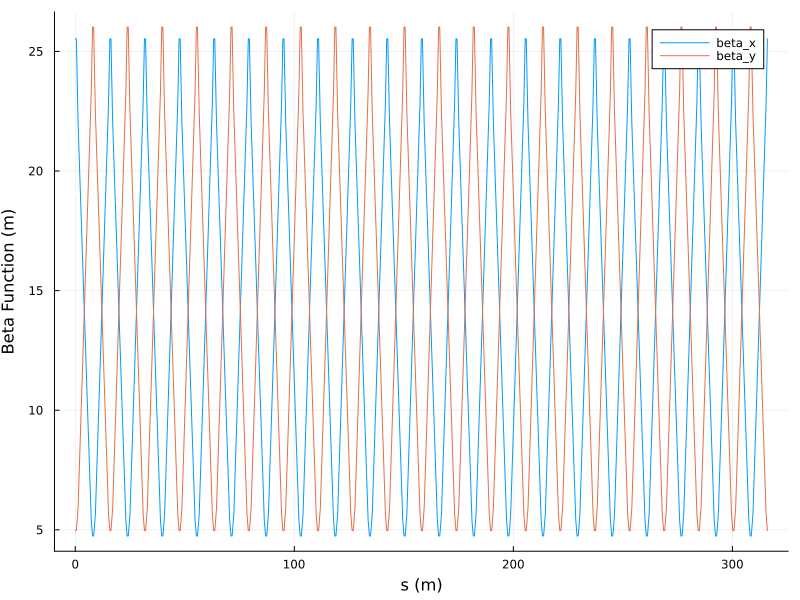

In [4]:
plt = plot(size=(800, 600))
plot!(plt, t.s, t.beta_1, label="beta_x")
plot!(plt, t.s, t.beta_2, label="beta_y")
xlabel!(plt, "s (m)")
ylabel!(plt, "Beta Function (m)")
display(plt)

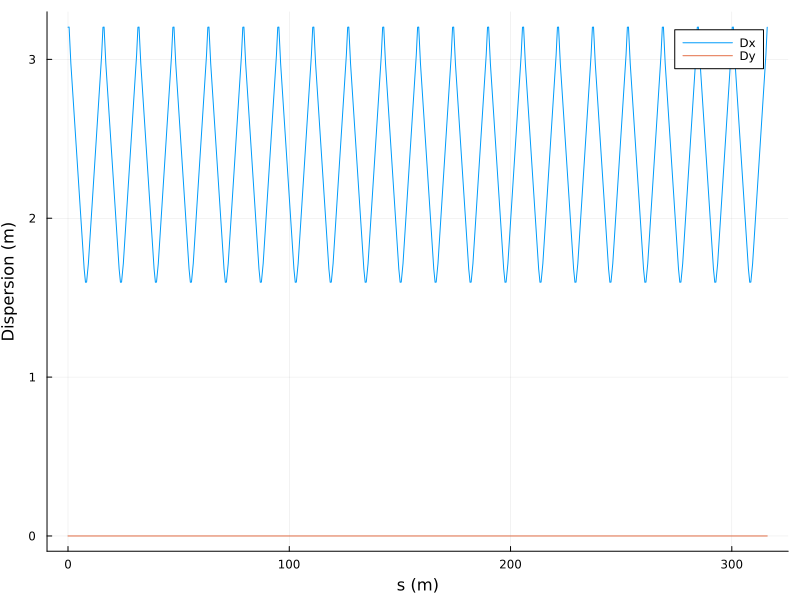

In [5]:
plt = plot(size=(800, 600))
plot!(plt, t.s, t.eta_1, label="Dx")
plot!(plt, t.s, t.eta_2, label="Dy")
xlabel!(plt, "s (m)")
ylabel!(plt, "Dispersion (m)")
display(plt)

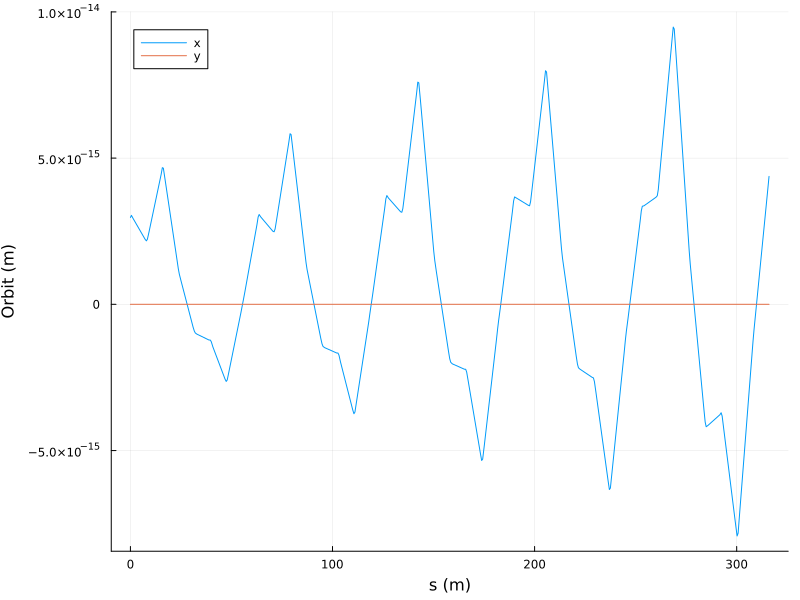

In [6]:
plt = plot(size=(800, 600))
plot!(plt, t.s, t.orbit_x, label="x")
plot!(plt, t.s, t.orbit_y, label="y")
xlabel!(plt, "s (m)")
ylabel!(plt, "Orbit (m)")
display(plt)

## Try turn on the first horizontal corrector

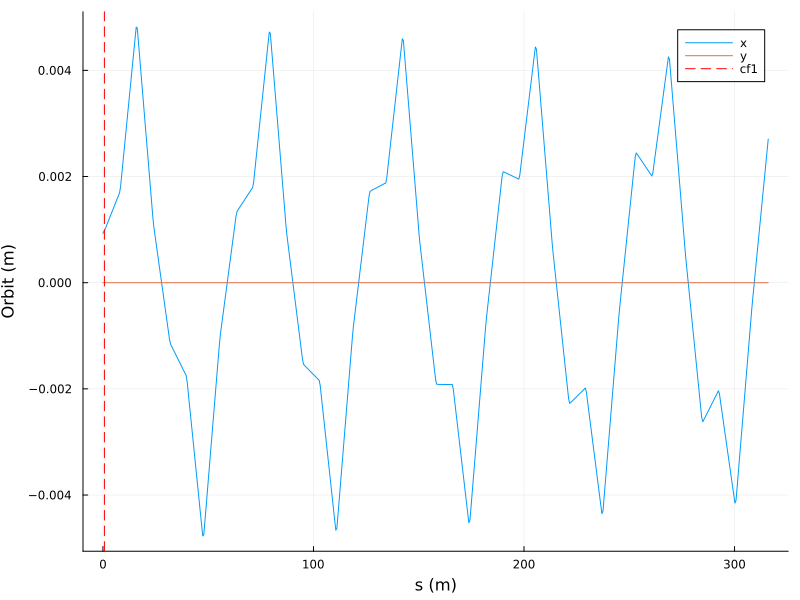

In [7]:
hkick1 = 0.0001
t_hor = twiss(simple_ring)

plt = plot(size=(800, 600))
plot!(plt, t_hor.s, t_hor.orbit_x, label="x")
plot!(plt, t_hor.s, t_hor.orbit_y, label="y")
vline!([simple_ring.line[4].s], line=:dash, color=:red,label="cf1")
xlabel!(plt, "s (m)")
ylabel!(plt, "Orbit (m)")
display(plt)

## Now try turn on the first vertical corrector

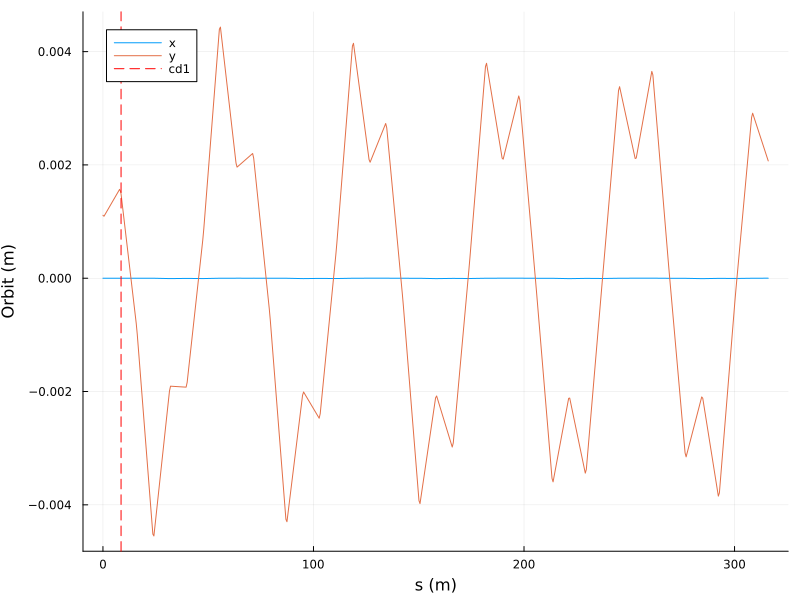

In [8]:
hkick1 = 0
vkick1 = 0.0001
t_ver = twiss(simple_ring)

plt = plot(size=(800, 600))
plot!(plt, t_ver.s, t_ver.orbit_x, label="x")
plot!(plt, t_ver.s, t_ver.orbit_y, label="y")
vline!([simple_ring.line[12].s], line=:dash, color=:red,label="cd1")
xlabel!(plt, "s (m)")
ylabel!(plt, "Orbit (m)")
display(plt)

# Base parameters

In [9]:
# --- Base parameters ---
D = Descriptor(6,1,40,1) # 6 variables, 1st order, 40 parameters, 1st order

# quadreupole and sextupole strengths
K1 = 0.36
K2 = 0.1

# reference parameters for the ring
Ncell = 20
sp = Species("proton")
energy = 1e9;

# Define one FODO cell

In [10]:
"""
    fodo_cell(Ncells=20, hkick_strength=0.0, vkick_strength=0.0)

Constructs a single FODO cell with configurable bending based on the number of cells.

# Description
This function defines one periodic cell of a FODO-type lattice consisting of 
quadrupoles, sextupoles, dipoles, drifts, and beam position monitors (BPMs).  
The cell structure can optionally include horizontal and vertical kickers 
to introduce local orbit distortions.  
The total bending angle per cell is determined by the number of cells `Ncells`, 
so that a full ring can be formed when `Ncells` cells are concatenated.

# Arguments
- `Ncells::Int`: Number of cells in the full ring (default = 20).  
  The bending angle per cell is `π / Ncells`.
- `hkick_strength::Float64`: Integrated horizontal kicker strength (default = 0.0).
- `vkick_strength::Float64`: Integrated vertical kicker strength (default = 0.0).

# Returns
- `Vector{LineElement}`: A list of lattice elements defining one FODO cell, including:
    - Quadrupoles for focusing (`+K1`) and defocusing (`-K1`)
    - Sextupoles for chromatic correction (`+K2` and `-K2`)
    - Dipoles (`SBend`) providing bending with angle `π/Ncells`
    - Drift spaces separating magnetic elements
    - Horizontal and vertical kickers (`HKicker`, `VKicker`)
    - Markers (`BPM`) for beam position monitoring

# Example
```julia
cell = fodo_cell(Ncells=16, hkick_strength=1e-4);
```
This creates one FODO cell for a 16-cell ring with a horizontal kicker active.
"""
function fodo_cell(Ncells=20, hkick_strength=0.0, vkick_strength=0.0)
    return [Quadrupole(Kn1=+K1, L=0.5),
            Marker(name="BPM",L=0.0),
            Sextupole(Kn2=+K2, L=0.2),
            HKicker(Kn0L=hkick_strength, L=0.0),
            Marker(name="BPM",L=0.0),
            Drift(L=0.6), 
            SBend(L=6.0, angle=pi/Ncells), 
            Drift(L=0.6),
            Quadrupole(Kn1=-K1, L=0.5),
            Marker(name="BPM",L=0.0),
            Sextupole(Kn2=-K2, L=0.2),
            VKicker(Ks0L=vkick_strength, L=0.0),
            Marker(name="BPM",L=0.0),
            Drift(L=0.6), 
            SBend(L=6.0, angle=pi/Ncells), 
            Drift(L=0.6)]
end

fodo_cell

In [11]:
?fodo_cell

search: fodo_cell fodo_line fodo_line1



```julia
fodo_cell(Ncells=20, hkick_strength=0.0, vkick_strength=0.0)
```

Constructs a single FODO cell with configurable bending based on the number of cells.

# Description

This function defines one periodic cell of a FODO-type lattice consisting of  quadrupoles, sextupoles, dipoles, drifts, and beam position monitors (BPMs).   The cell structure can optionally include horizontal and vertical kickers  to introduce local orbit distortions.   The total bending angle per cell is determined by the number of cells `Ncells`,  so that a full ring can be formed when `Ncells` cells are concatenated.

# Arguments

  * `Ncells::Int`: Number of cells in the full ring (default = 20).   The bending angle per cell is `π / Ncells`.
  * `hkick_strength::Float64`: Integrated horizontal kicker strength (default = 0.0).
  * `vkick_strength::Float64`: Integrated vertical kicker strength (default = 0.0).

# Returns

  * `Vector{LineElement}`: A list of lattice elements defining one FODO cell, including:

      * Quadrupoles for focusing (`+K1`) and defocusing (`-K1`)
      * Sextupoles for chromatic correction (`+K2` and `-K2`)
      * Dipoles (`SBend`) providing bending with angle `π/Ncells`
      * Drift spaces separating magnetic elements
      * Horizontal and vertical kickers (`HKicker`, `VKicker`)
      * Markers (`BPM`) for beam position monitoring

# Example

```julia
cell = fodo_cell(Ncells=16, hkick_strength=1e-4);
```

This creates one FODO cell for a 16-cell ring with a horizontal kicker active.


# Building a ring using the FODO cells

In [12]:
"""
    build_ring(Ncells::Int64, species=Species("proton"), E_ref=1e9)

Constructs a complete ring model composed of multiple FODO cells, each containing
quadrupoles, sextupoles, dipoles, and correctors.

# Arguments
- `Ncells::Int64`: Number of FODO cells to include in the ring.
- `species`: Particle species used for the beamline (default: proton).
- `E_ref`: Reference beam energy in electronvolts (default: `1e9` eV).

# Description
This function assembles a circular accelerator ring by repeating `Ncells` FODO
cells. Each cell is generated by calling [`fodo_cell`] with horizontal and
vertical corrector strengths defined by the global parameter array `params(D)`.
The first `Ncells` elements of `params(D)` set the horizontal corrector
strengths, while the next `Ncells` elements define the vertical ones.

The resulting lattice is concatenated into a single beamline sequence, which is
then wrapped into a `Beamline` object with the specified reference species and
energy.

# Returns
- `Beamline`: A fully constructed beamline object representing the complete ring.

# Example
```julia
ring = build_ring(20, species=Species("proton"), E_ref=1e9);
```
This creates a 20-cell ring for 1GeV protons.
"""
function build_ring(Ncells::Int64, species=Species("proton"), E_ref=1e9)
    ring_cells = Vector{Vector}()
    for i = 1:Ncells
        push!(ring_cells, fodo_cell(Ncells, -params(D)[i], -params(D)[i+20]))
    end
    ring_line = vcat(ring_cells...)
    return Beamline(ring_line, species_ref=species, E_ref=E_ref)
end

build_ring

In [13]:
?build_ring

search: build_ring bitstring simple_ring SubString include_string



```julia
build_ring(Ncells::Int64, species=Species("proton"), E_ref=1e9)
```

Constructs a complete ring model composed of multiple FODO cells, each containing quadrupoles, sextupoles, dipoles, and correctors.

# Arguments

  * `Ncells::Int64`: Number of FODO cells to include in the ring.
  * `species`: Particle species used for the beamline (default: proton).
  * `E_ref`: Reference beam energy in electronvolts (default: `1e9` eV).

# Description

This function assembles a circular accelerator ring by repeating `Ncells` FODO cells. Each cell is generated by calling [`fodo_cell`] with horizontal and vertical corrector strengths defined by the global parameter array `params(D)`. The first `Ncells` elements of `params(D)` set the horizontal corrector strengths, while the next `Ncells` elements define the vertical ones.

The resulting lattice is concatenated into a single beamline sequence, which is then wrapped into a `Beamline` object with the specified reference species and energy.

# Returns

  * `Beamline`: A fully constructed beamline object representing the complete ring.

# Example

```julia
ring = build_ring(20, species=Species("proton"), E_ref=1e9);
```

This creates a 20-cell ring for 1GeV protons.


In [14]:
r0 = build_ring(Ncell, sp, energy);

## index of all BPMs

In [15]:
id_bpm = [i for (i, elem) in enumerate(r0.line) if occursin("BPM", elem.name)];
ids_bpm = [elem.s for (i, elem) in enumerate(r0.line) if occursin("BPM", elem.name)];

# Build orbit response matrix

In [16]:
"""
    build_orm(ring::Beamline)

Constructs the full Orbit Response Matrix (ORM) for a given beamline.

# Description
This function computes the orbit response of all beam position monitors (BPMs) 
to every available horizontal and vertical corrector in the provided `ring`.  
It propagates a reference bunch through the beamline, linearizes the dynamics 
using differential algebra, and extracts the Jacobian elements that describe 
how the transverse beam positions respond to small changes in corrector strengths.

# Algorithm
1. Initializes a reference bunch at the design orbit using `vars(D)`.
2. Tracks the bunch through the ring to obtain the one-turn map.
3. Normalizes and factorizes the map into linear components.
4. For each BPM, tracks the bunch up to that location.
5. Computes the horizontal and vertical orbit response using 
   the Jacobian of the differential algebra coordinates with respect to 
   corrector parameters.
6. Assembles the results into a full ORM matrix.

# Returns
- `orm::Matrix{Float64}`:  
  A matrix of size `(n_BPMs × n_correctors)`, where each element represents 
  the orbit change (Δx or Δy) at a BPM due to a unit kick at a corrector.

# Notes
- The first half of the ORM columns correspond to horizontal correctors, 
  and the second half correspond to vertical correctors.
- The BPM elements are identified automatically from the beamline using their names.

# Example
```julia
ring = build_ring(20)
orm = build_orm(ring)
```
This calculates the orbit response matrix for a 20-cell ring.
"""
function build_orm(ring::Beamline)
    # create bunch
    b0 = Bunch(vars(D), species=ring.species_ref, R_ref=ring.R_ref)

    # find indices of BPMs in the ring
    id_bpm = [i for (i, elem) in enumerate(ring.line) if occursin("BPM", elem.name)]

    # track through ring once
    track!(b0, ring)

    m = DAMap(v = b0.coords.v)
    a = normal(m)
    a0, a1, a2 = factorize(a)

    b1 = Bunch(a0.v[1:6], species=ring.species_ref, R_ref=ring.R_ref)

    # create full ORM
    orm = Matrix{Float64}(undef, length(id_bpm), length(params(D)))

    for (j, i) in enumerate(id_bpm)
        b2 = deepcopy(b1)
        for k = 1:i
            track!(b2, ring.line[k])
        end
        
        # first 6 columns are 6D beam matrix
        # starting from column 7, first half is horizontal correctors
        # second half is vertical correctors
        corr_len = Int(length(params(D)) / 2)
        hor = GTPSA.jacobian(b2.coords.v, include_params=true)[1,7:6+corr_len]
        ver = GTPSA.jacobian(b2.coords.v, include_params=true)[3,7+corr_len:end]
        
        orm[j,1:corr_len] = hor
        orm[j,corr_len+1:end] = ver
    end
    return orm
end

build_orm

In [17]:
?build_orm

search: build_orm build_ring



```julia
build_orm(ring::Beamline)
```

Constructs the full Orbit Response Matrix (ORM) for a given beamline.

# Description

This function computes the orbit response of all beam position monitors (BPMs)  to every available horizontal and vertical corrector in the provided `ring`.   It propagates a reference bunch through the beamline, linearizes the dynamics  using differential algebra, and extracts the Jacobian elements that describe  how the transverse beam positions respond to small changes in corrector strengths.

# Algorithm

1. Initializes a reference bunch at the design orbit using `vars(D)`.
2. Tracks the bunch through the ring to obtain the one-turn map.
3. Normalizes and factorizes the map into linear components.
4. For each BPM, tracks the bunch up to that location.
5. Computes the horizontal and vertical orbit response using  the Jacobian of the differential algebra coordinates with respect to  corrector parameters.
6. Assembles the results into a full ORM matrix.

# Returns

  * `orm::Matrix{Float64}`:   A matrix of size `(n_BPMs × n_correctors)`, where each element represents  the orbit change (Δx or Δy) at a BPM due to a unit kick at a corrector.

# Notes

  * The first half of the ORM columns correspond to horizontal correctors,  and the second half correspond to vertical correctors.
  * The BPM elements are identified automatically from the beamline using their names.

# Example

```julia
ring = build_ring(20)
orm = build_orm(ring)
```

This calculates the orbit response matrix for a 20-cell ring.


# Calculates the full ORM

In [18]:
orm = build_orm(r0);

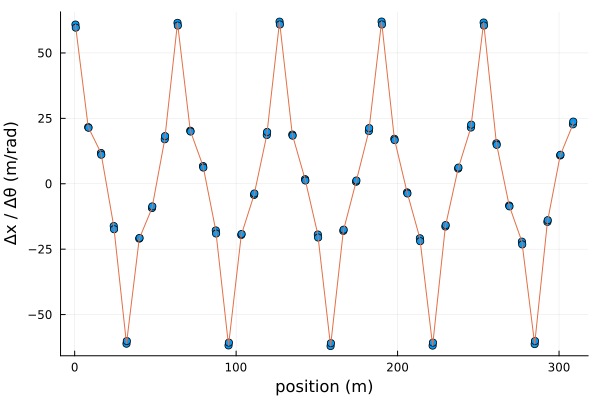

In [19]:
Plots.scatter(ids_bpm, orm[:,1],label="")
Plots.plot!(ids_bpm, orm[:,1],label="")
xlabel!("position (m)")
ylabel!("Δx / Δθ (m/rad)")

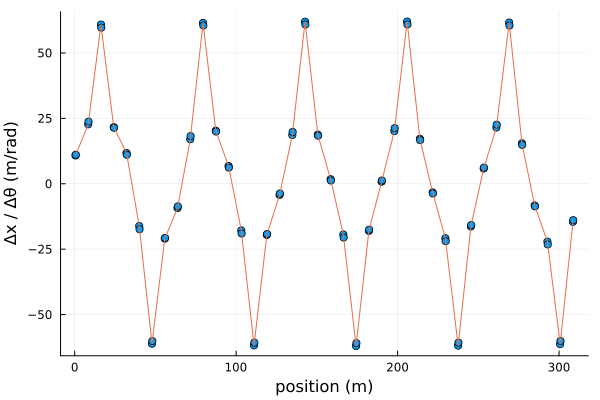

In [20]:
Plots.scatter(ids_bpm, orm[:,2],label="")
Plots.plot!(ids_bpm, orm[:,2],label="")
xlabel!("position (m)")
ylabel!("Δx / Δθ (m/rad)")

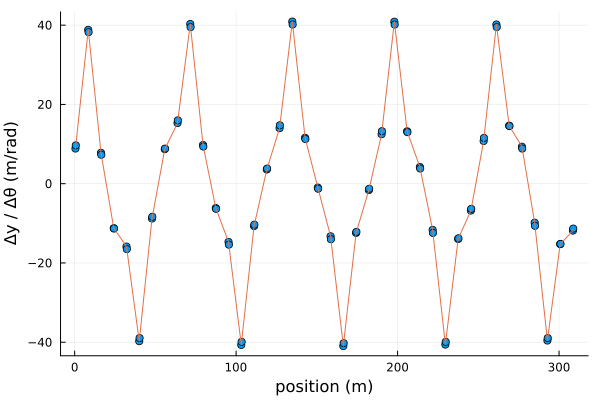

In [21]:
Plots.scatter(ids_bpm, orm[:,21],label="")
Plots.plot!(ids_bpm, orm[:,21],label="")
xlabel!("position (m)")
ylabel!("Δy / Δθ (m/rad)")

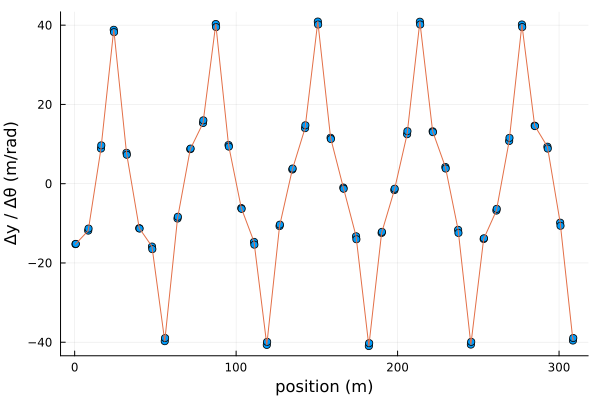

In [22]:
Plots.scatter(ids_bpm, orm[:,22],label="")
Plots.plot!(ids_bpm, orm[:,22],label="")
xlabel!("position (m)")
ylabel!("Δy / Δθ (m/rad)")

# Now we can compare the simple way and the normal form way to calculate ORM

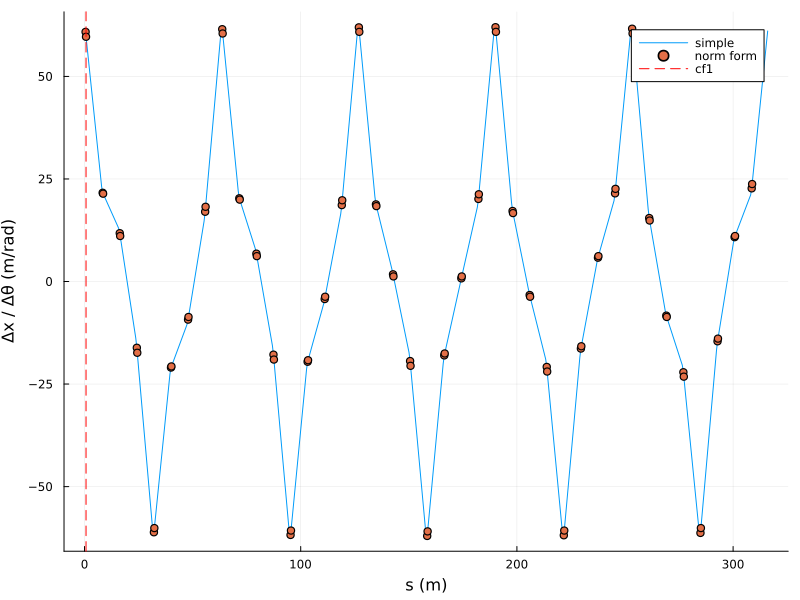

In [29]:
hkick1 = 0.0001
t_hor_pos = twiss(simple_ring)

hkick1 = -0.0001
t_hor_neg = twiss(simple_ring);


plt = plot(size=(800, 600))
plot!(plt, t_hor_pos.s, (t_hor_pos.orbit_x - t_hor_neg.orbit_x) / 0.0002, label="simple")
scatter!(ids_bpm, orm[:,1],label="norm form")
vline!([simple_ring.line[4].s], line=:dash, color=:red,label="cf1")
xlabel!(plt, "s (m)")
ylabel!(plt, "Δx / Δθ (m/rad)")
display(plt)

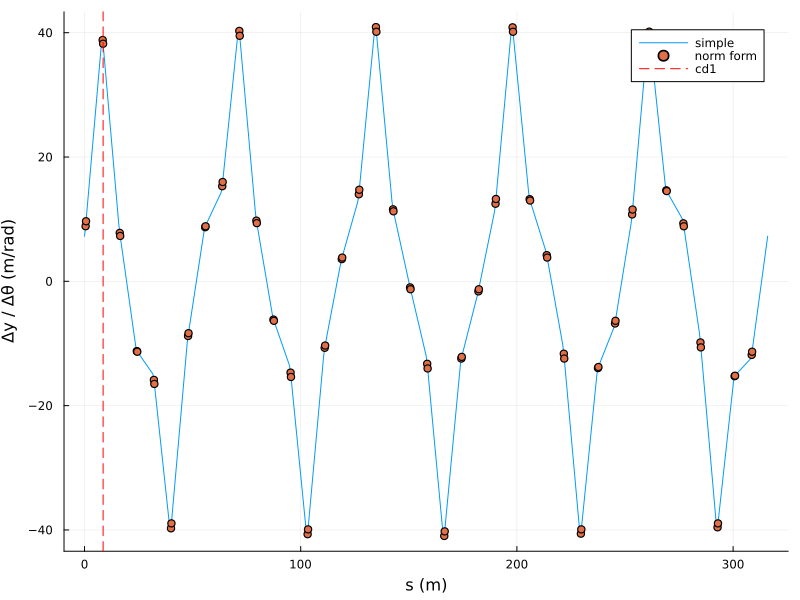

In [28]:
vkick1 = 0.0001
t_ver_pos = twiss(simple_ring)

vkick1 = -0.0001
t_ver_neg = twiss(simple_ring);

plt = plot(size=(800, 600))
plot!(plt, t_ver_pos.s, (t_ver_pos.orbit_y - t_ver_neg.orbit_y) / 0.0002, label="simple")
scatter!(ids_bpm, orm[:,21],label="norm form")
vline!([simple_ring.line[12].s], line=:dash, color=:red,label="cd1")
xlabel!(plt, "s (m)")
ylabel!(plt, "Δy / Δθ (m/rad)")
display(plt)